<a href="https://colab.research.google.com/github/pthkbs123/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/cgan/cgan_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGAN
---

In [3]:
IMG_SHAPE = (28,28,1)
NOISE_DIM = 128
LABEL_DIM = 10

## 데이터 로더

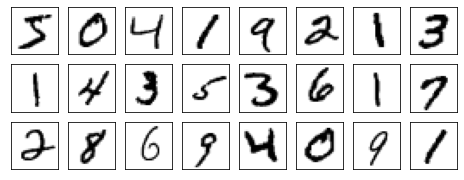

((60000, 28, 28, 1), (60000, 10))

In [4]:
from data_loader import *
from utils import display_sample_img
x_train, y_train, _, _ = mnist_loader(True)
display_sample_img(x_train, (3,8), True)
x_train.shape, y_train.shape
# 이미지 -1~1 제너레이터가 -1~1까지의 이미지를 생성해야한다.

## 모델 구성

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from tensorflow.keras import backend as K

class BuildModel():
  def __init__(self, img_shape, z_dim, label_dim):
    self.img_shape = img_shape
    self.z_dim = z_dim
    self.label_dim = label_dim

  def build_gene(self, 
                 activation = 'selu',
                 last_activation='sigmoid',
                 kernel_size=5):

    h, w, ch = self.img_shape
    
    z = layers.Input(shape=[self.z_dim,], name='noise')
    c = layers.Input(shape=[self.label_dim,], name='condition')
    y = layers.concatenate([z, c])

    y = layers.Dense(int(w/4)*int(h/4)*128)(y)
    y = layers.Reshape( [int(w/4),int(h/4),128] )(y)
    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(64, kernel_size=5, padding='same', strides=2, activation=activation)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(ch, kernel_size=5, padding='same', strides=2, activation=last_activation)(y)
    
    return models.Model([z, c], y, name='Generator')

  def build_disc(self,
                 activation='relu',
                 last_activation='sigmoid',
                 kernel_size=5):

    h, w, ch = self.img_shape
    def _expand_label_input(x):
      y = K.expand_dims(x, axis=1)
      y = K.expand_dims(y, axis=1)
      y = K.tile(y, [1, int(h/2), int(w/2), 1])
      return y

    in_x = layers.Input(shape=self.img_shape, name='disc_input_image')
    x = layers.Conv2D(64, kernel_size=kernel_size, strides=2, padding='same', activation=activation)(in_x)

    in_c = layers.Input(shape= self.label_dim, name='disc_input_label')
    c = layers.Lambda(_expand_label_input)(in_c)
    
    y = layers.concatenate([x, c], axis=3)
    y = layers.Conv2D(128, kernel_size=kernel_size, strides=2, padding='same', activation=activation)(y)
    y = layers.Dropout(.5)(y)
    y = layers.Flatten()(y)

    y = layers.Dense(1, activation=last_activation)(y)
    return models.Model([in_x,in_c], y, name='Discriminator')

In [6]:
# from model import BuildModel
builder = BuildModel(IMG_SHAPE, NOISE_DIM, LABEL_DIM)
gene = builder.build_gene(last_activation='tanh') # tanh : -1 ~ 1 아웃풋  sigmoid: 0~1 아웃풋
disc = builder.build_disc()
gene.summary()
disc.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 condition (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 138)          0           ['noise[0][0]',                  
                                                                  'condition[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 6272)         871808      ['concatenate[0][0]']    

## 학습

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from utils import display_sample_img
import numpy as np

class CGAN():
  def __init__(self, gene, disc, img_shape, noise_dims, label_dims):
    self.name = 'GAN'
    self.gene = gene
    self.disc = disc
    self.img_shape = img_shape
    self.noise_dims = noise_dims
    self.label_dims = label_dims

  def compile(self, 
              loss = 'binary_crossentropy',
              optimizer = 'adam'):
    
    self.disc.compile(loss = loss, optimizer = optimizer)
    self.disc.trainable = False
    
    # 인풋이 추가
    input_noise = layers.Input(shape=self.noise_dims)
    input_label = layers.Input(shape=self.label_dims)

    fake_img = self.gene([input_noise, input_label])
    logit = self.disc([fake_img, input_label])

    self.cgan = models.Model([input_noise, input_label], logit, name=self.name)
    self.cgan.compile(loss = loss, optimizer = optimizer)

  def _make_datasets(self, x_data, y_data):
      dataset = tf.data.Dataset.from_tensor_slices( (x_data, y_data) ).shuffle(1)
      dataset = dataset.batch(self.batch_size, drop_remainder=True).prefetch(1)
      return dataset

  def _make_constants(self):
      zeros = tf.constant([0.], shape=[self.batch_size, 1])
      ones = tf.constant([1.], shape=[self.batch_size, 1] )
      return zeros, ones
  
  def _make_random(self):
      rnd_noises = tf.random.normal(shape=[self.batch_size, self.noise_dims])
      rnd_labels = np.random.randint(0, self.label_dims, self.batch_size)
      rnd_labels = utils.to_categorical(rnd_labels, self.label_dims)
      return rnd_noises, rnd_labels

  def fit(self, 
          x_data,
          y_data, 
          epochs=1,
          batch_size=32,
          standard=False
          ):
    
    # setting
    self.batch_size = batch_size
    train_ds = self._make_datasets(x_data,y_data)
    zeros, ones = self._make_constants()

    # for generator
    seed_noises = tf.random.normal(shape = [30, self.noise_dims])
    seed_labels = np.arange(10)
    seed_labels = utils.to_categorical(seed_labels, 10)
    seed_labels = np.tile(seed_labels, (3,1))

    # train
    history = {'d_loss':[], 'g_loss':[]}
    for epoch in range(1+epochs):
      if epoch>0: 
        for h in history: history[h].append(0)

        for real_imgs, real_labels in train_ds:           
            # phase 1 - training the discriminator
            rnd_noises, _ = self._make_random()
            fake_imgs = self.gene.predict_on_batch([rnd_noises, real_labels])
            
            self.disc.trainable = True
            d_loss_real = self.disc.train_on_batch([real_imgs, real_labels], ones)
            d_loss_fake = self.disc.train_on_batch([fake_imgs, real_labels], zeros)
            d_loss = (0.5*d_loss_real) + (0.5*d_loss_fake)
            
            # phase 2 - training the generator
            self.disc.trainable = False
            rnd_noises, rnd_labels = self._make_random()
            g_loss = self.cgan.train_on_batch([rnd_noises, rnd_labels] , ones)
            
            history['d_loss'][-1]+=d_loss
            history['g_loss'][-1]+=g_loss
        
        # end 1 epoch        
        print('* epoch: %i, d_loss: %f, g_loss: %f'%( epoch
                                                    , history['d_loss'][-1]
                                                    , history['g_loss'][-1]))
      
      fake_imgs = self.gene.predict([seed_noises, seed_labels])
      display_sample_img(fake_imgs, (3,10), standard=standard, size=2)

In [8]:
model = CGAN(gene, disc, IMG_SHAPE, NOISE_DIM, LABEL_DIM)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=10e-8))
model.cgan.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 Generator (Functional)         (None, 28, 28, 1)    1079041     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 Discriminator (Functional)     (None, 1)            244865      ['Generator[0][0]',            

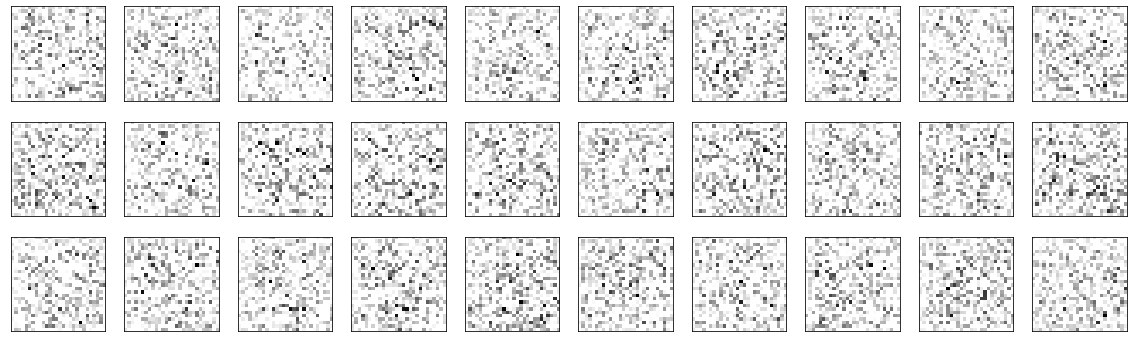

* epoch: 1, d_loss: 1077.353065, g_loss: 2095.046794


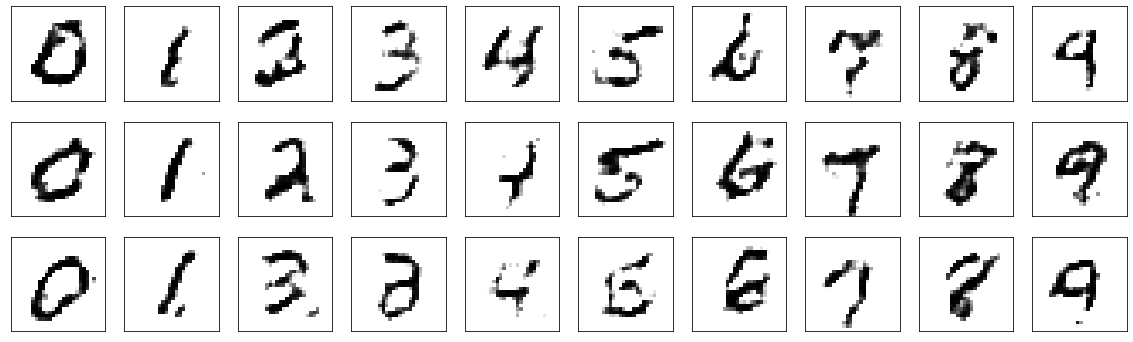

* epoch: 2, d_loss: 1072.844105, g_loss: 2129.014516


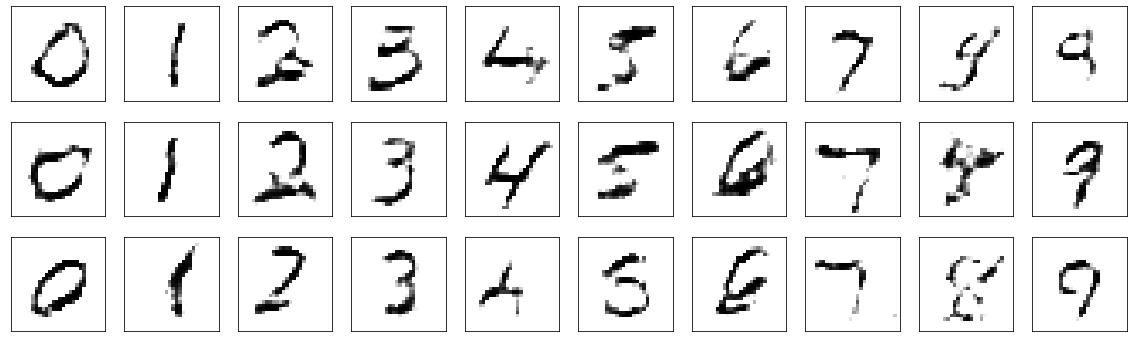

* epoch: 3, d_loss: 1113.244653, g_loss: 1976.094521


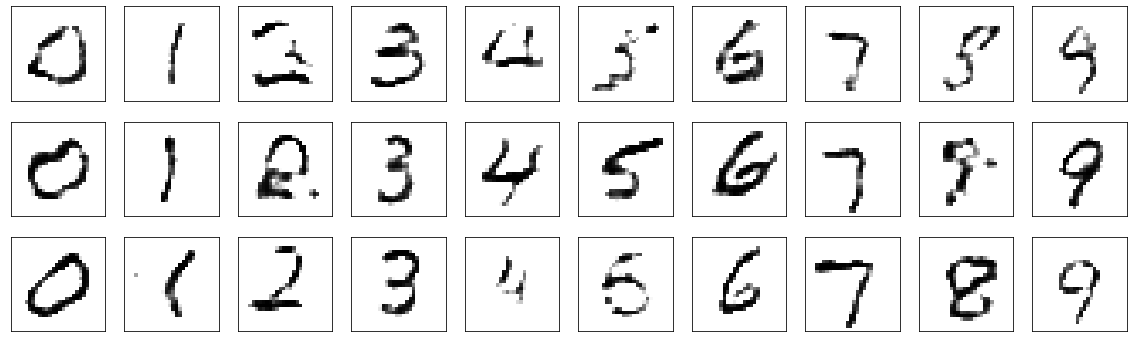

* epoch: 4, d_loss: 1109.764785, g_loss: 1985.062404


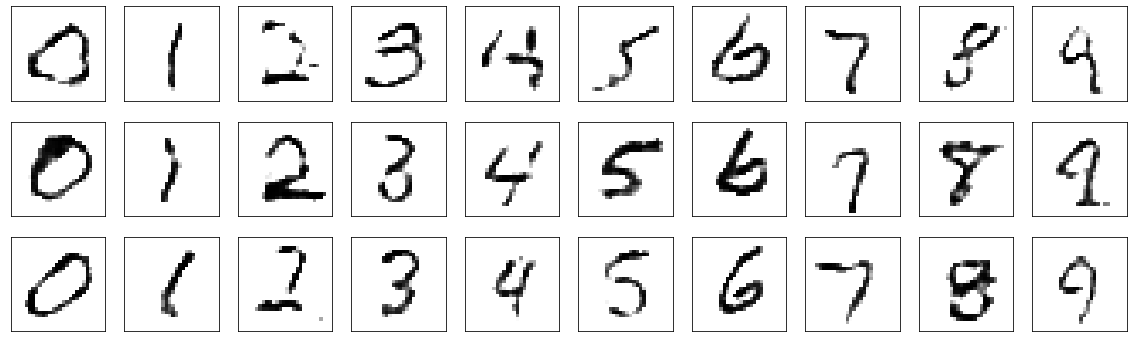

* epoch: 5, d_loss: 1096.260624, g_loss: 2022.561879


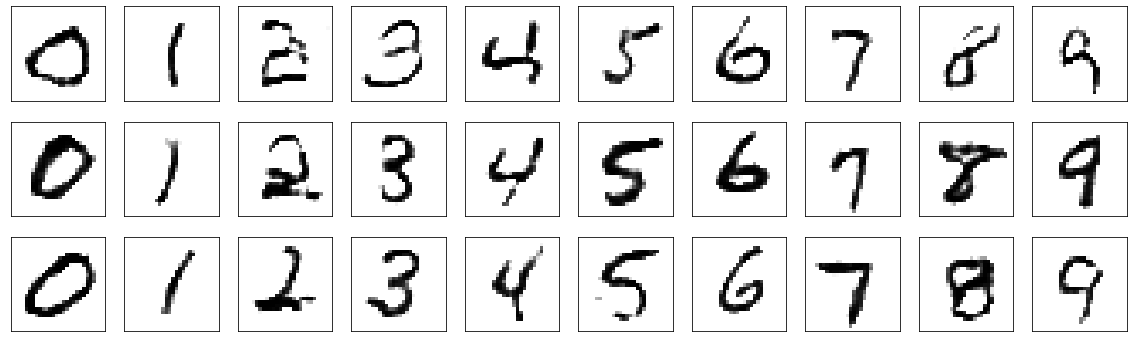

In [9]:
model.fit(x_train, y_train, epochs=5)